# Chemistry Analysis with Cantera

## Set up Cantera

In [1]:
# setup folder containing input files
!git clone https://github.com/BangShiuh/LAE-teaching.git

Cloning into 'LAE-teaching'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 22 (delta 5), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
# go to folder containing
%cd LAE-teaching/

/content/LAE-teaching


In [3]:
# install cantera python package
!pip install cantera
# import cantera python package
import cantera as ct
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 19.7 MB/s 
     |████████████████████████████████| 109 kB 63.6 MB/s 
     |████████████████████████████████| 546 kB 68.6 MB/s 


In [4]:
# create a cantera solution object with the input file
ct.suppress_thermo_warnings()
gas = ct.Solution("A2NOx.yaml", transport_model=None)

## Thermodynamic Properties

### Cycle Analysis

Text(0, 0.5, 'Temperature [K]')

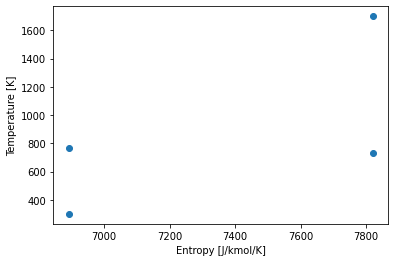

In [5]:
# Array to store data
s_arr = []
T_arr = []

# define gas properties at location one
gas.TPX = 300, ct.one_atm, "O2: 1.0, N2:3.76"
s_arr.append(gas.s)
T_arr.append(gas.T)

# compressor (assume no loss)
P3 = 30 * ct.one_atm
gas.SP = gas.s, P3
s_arr.append(gas.s)
T_arr.append(gas.T)

# Heating stage (combustion)
gas.TP = 1700, 30 * ct.one_atm
s_arr.append(gas.s)
T_arr.append(gas.T)

# Turbine (assume no loss)
gas.SP = gas.s, ct.one_atm

s_arr.append(gas.s)
T_arr.append(gas.T)

import matplotlib.pyplot as plt
plt.scatter(s_arr, T_arr, marker='o')
plt.xlabel("Entropy [J/kmol/K]")
plt.ylabel("Temperature [K]")

### Heating Value

In [6]:
# Define gas state for reactants at 300 K (O2:1.0, CH4:0.5, N2:3.76)
gas.TPX = 300, ct.one_atm, "O2:1.0, CH4:0.5, N2:3.76"
# Get reactants enthalpy (per mole)
H0 = gas.enthalpy_mole
# Define gas state for products at 300 K (CO2:0.5, H2O:1.0, N2:3.76)
gas.TPX = 300, ct.one_atm, "CO2:0.5, H2O:1.0, N2:3.76"
# Get products enthalpy (per mole)
H1 = gas.enthalpy_mole

print(H0 - H1)

76286993.31984524


### Adiabatic Flame Temperature

In [7]:
# Define gas state for reactants
gas.TPX = 300, ct.one_atm, "O2:1.0, CH4:0.5, N2:3.76"
# Get reactants enthalpy (per mass)
H0 = gas.enthalpy_mass
# Define gas state for products with the same enthalpy
gas.HPX = H0, ct.one_atm, "CO2:0.5, H2O:1.0, N2:3.76"

print(gas.T)

2326.9056116954334


## Reaction

In [8]:
# Information for reaction 8
r = gas.reaction(8)
print(r.equation)
print(r.rate.input_data) # Ea in [J/kmol]

# Define gas
gas.TPX = 300, ct.one_atm, "H2: 1.0, O: 0.1"

# forward rates of progress [kmol/m^3/s]
print(gas.forward_rates_of_progress[8])
print(gas.net_rates_of_progress[8])

# net production rate. length: number of species. [kmol/m^3/s]
print(gas.net_production_rates[gas.species_index("H2")])

# Heat production rate [W/m^3]
print(sum(gas.heat_production_rates))
gas.heat_production_rates[8]

# Heat release rate
# Get the total volumetric heat release rate [W/m^3].
print(np.dot(gas.net_production_rates, gas.partial_molar_enthalpies))
print(gas.heat_release_rate)

H2 + O <=> H + OH
{'rate-constant': {'A': 45.89000000000001, 'b': 2.7, 'Ea': 26191840.0}}
0.8401697050837116
0.8401697050837116
-0.8401697050837116
250987195716.97897
-250987195716.979
250987195716.97897


## Reactor

### A simple example using Cantera

In [9]:
# Define gas
gas.TP = 1500, ct.one_atm
# Set equivalence ratio
gas.set_equivalence_ratio(1.5, "POSF10325:1.0", "O2:0.2079,N2:0.7821,H2O:0.01")
# Set reactor
reactor = ct.IdealGasReactor(gas)
# Set reactor network
sim = ct.ReactorNet([reactor])
# Run simulation
sim.advance_to_steady_state()

### A more sophisticated example

In [10]:
# Thermodynamics cycle analysis result from NPSS
T3 = 827 # [K]
P3 = 3307415.1 # [Pa]
W4 = 53.16 # [kg/s]
Wf = 1.463 # [kg/s]
EINOx = 30.9 # [g/kg]
EICO = 0.54 # [g/kg]

In [11]:
from PerfectlyStirredReactor import PerfectlyStirredReactor
from PlugFlowReactor import PlugFlowReactor

gas.TPX = T3, P3, "O2:1.0, N2:3.76"
air_reservoir = ct.Reservoir(gas)
gas.TP = T3, P3
# All fuel goes into the reactor but some air join in later
gas.set_equivalence_ratio(1.5, "POSF10325:1.0", "O2:0.2079,N2:0.7821,H2O:0.01")
W_reactor = Wf / gas.mixture_fraction("POSF10325:1.0", "O2:0.2079,N2:0.7821,H2O:0.01")
print(W_reactor)
# gas.set_mixture_fraction(mixFrac, "POSF10325: 1.0", "O2: 1.0, N2:3.76")

r1 = PerfectlyStirredReactor(gas, volume=0.001, mdot=W_reactor)
r1.advance_to_steady_state()
r1.outlet_gas.T

r2 = PlugFlowReactor(r1.outlet_gas, length=0.006, mdot_main=W_reactor,
                     side_flow=air_reservoir, mdot_side=W4-W_reactor)
r2.advance_to_exit(1000)
r2.outlet_gas.T

15.882370800757268


1777.7578148438884

In [12]:
# calculate emission index
EICO = r2.outlet_gas["CO"].Y * W4 / Wf * 1000
EINOx = (r2.outlet_gas["NO"].Y * (46.0/30.0) +
         r2.outlet_gas["NO2"].Y) * W4 / Wf * 1000

print(f"EICO = {EICO[0]}")
print(f"EINOx = {EINOx[0]}")

EICO = 0.28479776987263555
EINOx = 43.72698029669796
